In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping,CSVLogger
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt
import numpy as np
from equation_as2 import equation

In [9]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [10]:
train_x = pickle.load(open('./Data/train_pairs.pickle','rb'))
train_y = pickle.load(open('./Data/train_y.pickle','rb'))
test_x1 = pickle.load(open('./Data/test_pairs1.pickle','rb'))
test_y1 = pickle.load(open('./Data/test_y1.pickle','rb'))
test_x2 = pickle.load(open('./Data/test_pairs2.pickle','rb'))
test_y2 = pickle.load(open('./Data/test_y2.pickle','rb'))
test_x3 = pickle.load(open('./Data/test_pairs3.pickle','rb'))
test_y3 = pickle.load(open('./Data/test_y3.pickle','rb'))

In [11]:
train_x = train_x.astype('float32')
test_x1 = test_x1.astype('float32')
test_x2 = test_x2.astype('float32')
test_x3 = test_x3.astype('float32')
train_x /= 255
test_x1 /= 255
test_x2 /= 255
test_x3 /= 255

### define margin

In [12]:
Ass2_Equation = equation(0.7)

In [13]:
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0],2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0],2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0],2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [16]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu',name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation='relu',name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation='relu',name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu',name='block3_conv1')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2),name = 'block3_pool')(x)
    x = Flatten()(x)
    output = Dense(128, activation='relu',name = 'embeding')(x)    
    return Model(input_tensor, output)

In [17]:
base_network = create_base_network(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(equation.euclidean_distance,
                  output_shape=equation.eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 64)          1849

In [18]:
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=Ass2_Equation.contrastive_loss, optimizer=adam, metrics=[equation.accuracy])

In [19]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model8.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

W0929 10:39:36.628050 19296 deprecation.py:323] From C:\Users\tashi\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 148us/sample - loss: 4.3021 - accuracy: 0.5067 - val_loss: 0.2866 - val_accuracy: 0.4543
Epoch 2/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.2207 - accuracy: 0.5060 - val_loss: 0.2842 - val_accuracy: 0.4351
Epoch 3/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.2016 - accuracy: 0.5081 - val_loss: 0.3146 - val_accuracy: 0.4239
Epoch 4/200
60145/60145 [==============================] - 7s 110us/sample - loss: 0.1925 - accuracy: 0.5121 - val_loss: 0.2914 - val_accuracy: 0.4325
Epoch 5/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.1860 - accuracy: 0.5145 - val_loss: 0.2762 - val_accuracy: 0.4342
Epoch 6/200
60145/60145 [==============================] - 7s 111us/sample - loss: 0.1791 - accuracy: 0.5172 - val_loss: 0.3345 - val_accuracy: 0.4355
Epoch 7/200
60145/60145 [====================

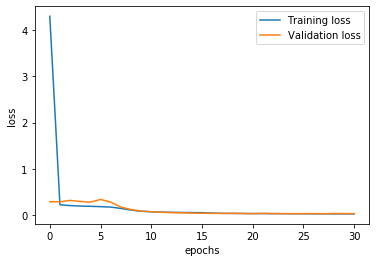

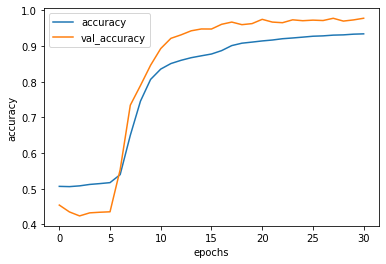

In [20]:
loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [21]:
test_x1[:1,0].shape

(1, 28, 28, 1)

In [22]:
pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

In [23]:
te_acc1 = compute_accuracy(test_y1, pred1)
te_acc2 = compute_accuracy(test_y2, pred2)
te_acc3 = compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

NameError: name 'compute_accuracy' is not defined

In [ ]:
index = 22
print(test_y2[index])
plt.imshow(np.reshape(test_x2[index,0],(28,28))*255,cmap = 'gray')
plt.show()
plt.imshow(np.reshape(test_x2[index,1],(28,28))*255,cmap = 'gray')
plt.show()

In [ ]:
model.save('./Data/model5_m0.8.h5')